In [1]:
import boto3
from datetime import datetime, timedelta
import json
import matplotlib.pyplot as plt
import requests
import time

In [2]:
# NOTE: You will need to set AWS access keys for the MCP environment

In [29]:
%%time
client = boto3.client('logs', region_name='us-west-2')

concept_type = "granules"
query = """
fields @timestamp, @message
| filter @message like "cmr.search.api"
| filter @message like ":short_name"
| parse '* * * [*] * * - Searching for """ \
+ concept_type + \
"""
from client * in format * with params *{:short_name "*", *' as date, time, ip, uuid, log_level, search_type, client, format, params1, short_name, params2
| stats count(*) by short_name
| filter client not like "MMT"
"""

log_group = 'cmr-search-ops'

start_query_response = client.start_query(
    logGroupName=log_group,
    startTime=int((datetime.today() - timedelta(weeks=1)).timestamp()),
    endTime=int(datetime.now().timestamp()),
    queryString=query,
)

query_id = start_query_response['queryId']

logs_response = None

while logs_response == None or logs_response['status'] == 'Running':
    print('Waiting for query to complete ...')
    time.sleep(10)
    logs_response = client.get_query_results(
        queryId=query_id
    )

ClientError: An error occurred (ExpiredTokenException) when calling the StartQuery operation: The security token included in the request is expired

In [7]:
#logs_response

In [10]:
restructured_data = []
for result in logs_response['results']:
    entry_data = {}
    for entry in result:
        entry_data[entry['field']] = entry['value']
    restructured_data.append(entry_data)

restructured_data

[{'short_name': 'GEDI01_B', 'count(*)': '2'},
 {'short_name': 'GEDI_L4B_Gridded_Biomass_2017', 'count(*)': '45'},
 {'short_name': 'SRTMGL1_COD', 'count(*)': '14'},
 {'short_name': 'AfriSAR_UAVSAR_Coreg_SLC', 'count(*)': '12'},
 {'short_name': 'AfriSAR_UAVSAR_Geocoded_Covariance', 'count(*)': '1'},
 {'short_name': 'AfriSAR_UAVSAR_SLC', 'count(*)': '4'},
 {'short_name': 'AfriSAR_UAVSAR_Geocoded_SLC', 'count(*)': '5'},
 {'short_name': 'ABLVIS2', 'count(*)': '21'},
 {'short_name': 'ATL08', 'count(*)': '1'},
 {'short_name': 'ABLVIS1B', 'count(*)': '42'},
 {'short_name': 'GEDI02_B', 'count(*)': '8'},
 {'count(*)': '1'},
 {'short_name': 'nceo_africa_2017', 'count(*)': '8'},
 {'short_name': 'ALOS_PSR_L1.5', 'count(*)': '1'},
 {'count(*)': '30'},
 {'short_name': 'ATL08_ARD-beta', 'count(*)': '4'},
 {'short_name': 'AFLVIS2', 'count(*)': '4'}]

In [26]:
count_data = {}

for result in restructured_data:
    if 'short_name' in result:
        count_data[result['short_name']] = int(result['count(*)'])

count_data = {k: v for k, v in sorted(count_data.items(), key=lambda item: item[1], reverse=True)}

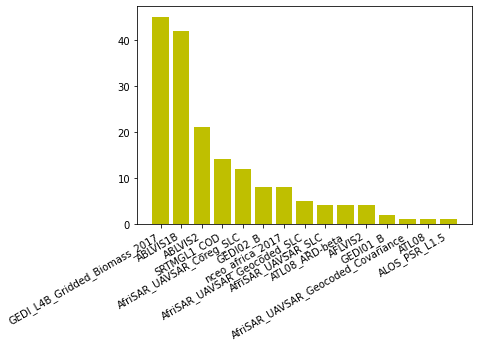

In [27]:
# data set
short_names = count_data.keys()
number_queries = count_data.values()

plt.bar(short_names, number_queries, color='y')
plt.xticks(rotation=30, ha='right')
plt.show()